# `CLOUD.jl` - 2D linear advection

In [25]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_dgmulti_p4M2_spectrum/"
results_path = "../results/advection_dgmulti_p4M2_spectrum/";

Define the physical problem

In [26]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law_central = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);
conservation_law_upwind = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=1.0);

Set up a collapsed-edge scheme of degree `p` with `M` intervals in each direction

In [32]:
M = 2
p = 4
p_map = p
form = WeakConservationForm()
mesh_strategy = ZigZag()
strategy=Lazy()

reference_approximation =ReferenceApproximation(
    DGMulti(p), Tri(),
    mapping_degree=p_map,
    N_plot=ceil(Int,50/M));
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), strategy=mesh_strategy), 
    reference_approximation.reference_element, 0.2)
spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation);
solver_central = Solver(conservation_law_central, spatial_discretization, form, strategy)
solver_upwind = Solver(conservation_law_upwind, spatial_discretization, form, strategy)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    grid_lines=false, plot_volume_nodes=true, geometry_resolution=20)

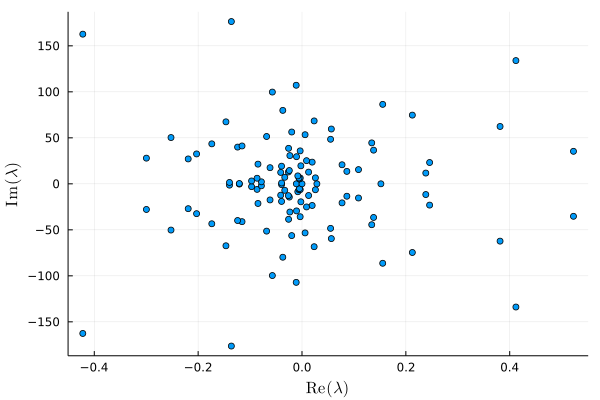

In [28]:
tol = 1.0e-12
n_s = prod(get_dof(spatial_discretization,conservation_law_central))
r = n_s-2
linear_analysis_central = LinearAnalysis(results_path,
    conservation_law_central, spatial_discretization, 
    LinearResidual(solver_central), r=r, tol=tol,
    use_data=false)
linear_results_central = analyze(linear_analysis_central)
plot_spectrum(linear_analysis_central, linear_results_central.λ,
    unit_circle=false, label="\\lambda", numbering=false)

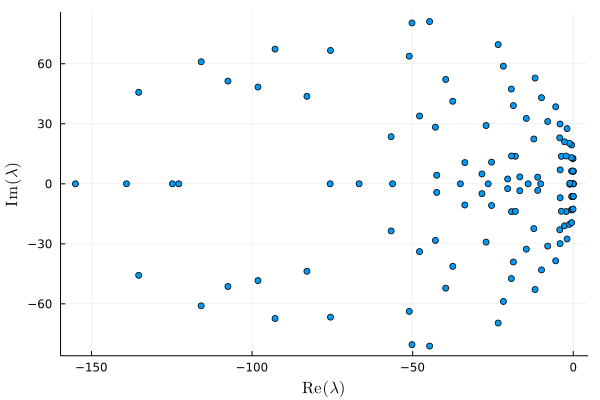

In [29]:
linear_analysis_upwind = LinearAnalysis(results_path,
    conservation_law_upwind, spatial_discretization, 
    LinearResidual(solver_upwind), r=r, tol=tol,
    use_data=false)
linear_results_upwind = analyze(linear_analysis_upwind)
plot_spectrum(linear_analysis_upwind, linear_results_upwind.λ,
    unit_circle=false, label="\\lambda", numbering=false)

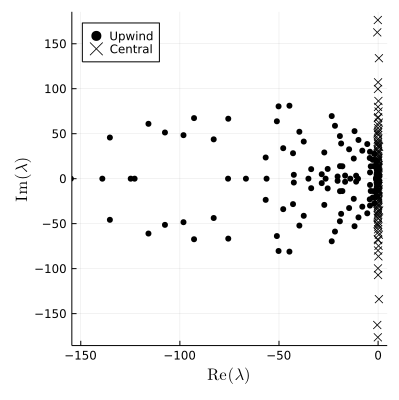

In [30]:
plot_spectrum(linear_analysis_upwind, [linear_results_upwind.λ, linear_results_central.λ], ylabel="\\lambda", xlims=[-150.0, 0.1], ylims=[-175.0, 175.0], title="spectra_multi.pdf")